In [78]:
#from models.nalu import NALU
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm_notebook as tqdm
from models.nalu import NALU
import torch
import torchvision.utils as vutils
import numpy as np
import torchvision.models as models
from torchvision import datasets
from tensorboardX import SummaryWriter
import datetime
import os


FEATURES_NUM = 100
epochs = 1000 # total epochs
epochs_transfer = epochs//2 # epochs for transfer learning
batch_size = 1
lr = 0.01
runs_per_operation = 10


import cv2
def make_Im(W):

    height,width = np.shape(W)
    new_height = height* 10
    
    im = np.zeros((3,new_height,width))
    w_tmp = W.detach().numpy()
    k = -1

    for i in range(new_height):
        if i % (new_height // 2) == 0:
            k += 1
        
        for channel in range(3):
            im[channel,i,:] = w_tmp[k,:]

    im = np.round(im * 255,0).astype(int)
    return im





def generate_synthetic_arithmetic_dataset(arithmetic_op, min_value, max_value, sample_size, set_size, boundaries = None):
    """
    generates a dataset of integers for the synthetics arithmetic task

    :param arithmetic_op: the type of operation to perform on the sum of the two sub sections can be either :
    ["add" , "subtract", "multiply", "divide", "root", "square"]
    :param min_value: the minimum possible value of the generated integers
    :param max_value: the maximum possible value of the generated integers
    :param sample_size: the number of integers per sample
    :param set_size: the number of samples in the dataset
    :param boundaries: [Optional] an iterable of 4 integer indices in the following format :
    [start of 1st section, end of 1st section, start of 2nd section, end of 2nd section]
    if None, the boundaries are randomly generated.
    :return: the training dataset input, the training true outputs, the boundaries of the sub sections used
    """
    scaled_input_values = np.random.uniform(min_value, max_value, (set_size, sample_size))

    if boundaries is None:
        boundaries = [np.random.randint(sample_size) for i in range(4)]
        boundaries = sorted(boundaries)
        
        if boundaries[1] == boundaries[0]:
            if boundaries[1] < sample_size-1:
                boundaries[1] =boundaries[1]+ 1
            else:
                boundaries[0] = boundaries[0] - 1
                
        if boundaries[3] == boundaries[2]:
            if boundaries[3] < sample_size-1:
                boundaries[3] =boundaries[3]+ 1
            else:
                boundaries[2] =boundaries[2]- 1
    else:
        if len(boundaries) != 4:
            raise ValueError("boundaries is expected to be a list of 4 elements but found {}".format(len(boundaries)))

    a = np.array([np.sum(sample[boundaries[0]:boundaries[1]]) for sample in scaled_input_values])
    b = np.array([np.sum(sample[boundaries[2]:boundaries[3]]) for sample in scaled_input_values])

    true_outputs = None
    if "add" in str.lower(arithmetic_op):
        true_outputs = a + b
    elif "sub" in str.lower(arithmetic_op):
        true_outputs = a - b
    elif "mult" in str.lower(arithmetic_op):
        true_outputs = a * b
    elif "div" in str.lower(arithmetic_op):
        true_outputs = a / b
    elif "square" == str.lower(arithmetic_op):
        true_outputs = a * a
    elif "root" in str.lower(arithmetic_op):
        true_outputs = np.sqrt(a)
    
    scaled_input_values = torch.tensor(scaled_input_values, dtype=torch.float32)
    true_outputs = torch.tensor(true_outputs, dtype=torch.float32).unsqueeze(1)
        
    return scaled_input_values, true_outputs, boundaries


nancounter = 0
totalcounter = 0
interpolations = [True, False]
for interpolation in interpolations:
    
    if interpolation:
        training_range = [0,10]
        test_range = [0,10]
    else:
        training_range = [0,10]
        test_range = [0,100]
    
    operators = ['add', 'sub', 'mult','div','square','root']
    # Transfer learning operators: trans has to change W, cis has to change G
    operators_trans = ['sub', 'add', 'div', 'mult', 'root', 'square']
    operators_cis = ['mult', 'div', 'add', 'sub', 'root', 'square']
    
    for j in range(len(operators)): # changed this, so there are not 3 i-indexes
        operator = operators[j]
        first_losses = []
        last_losses = []
        
        for i in range(runs_per_operation):
            totalcounter += 1
            operator = operators[j]
            #print(j,i,operator,operators_trans[j])
                        
            np.random.seed(i)
            
            # added this
            skiploop = 0
                
            in_dim = FEATURES_NUM
            hidden_dim = 2
            out_dim = 1
            num_layers = 2

            dim = in_dim # dimensition for generating data

            model = NALU(num_layers, in_dim, hidden_dim, out_dim)

            optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)

            experiment = "int_" + str(interpolation) + ",op_" + operator + ",to_" + operators_trans[j] + \
                ",run_" + str(i) + ",lr_" + str(lr) + ",bs_" + str(batch_size) + ",f_" + str(FEATURES_NUM) + \
                ",tr-r_" + str(training_range) + ",te-r_" +str(test_range)
            exp = "exp=" + str(j) + "/" # should this be j?
            Nalues = [exp + 'SelectorNALU/', exp + 'operatorNalu/']
            #print(experiment)
            #print(exp)
            #print(Nalues)
            
            path = 'checkpoints_change_of_operators/' + experiment + '/'
            if not os.path.exists('checkpoints_change_of_operators'):
                os.mkdir('checkpoints_change_of_operators')
            if not os.path.exists('checkpoints_change_of_operators/' + experiment):
                os.mkdir('checkpoints_change_of_operators/' + experiment)

            writer = SummaryWriter(path)
       
            
            for epoch in tqdm(range(epochs)):
                ## Generate dataset for the first operation ##############################
                # Moved all of the data generation down here
                if epoch == 0:
                    X_train, y_train, boundaries = generate_synthetic_arithmetic_dataset(operator, training_range[0], training_range[1], FEATURES_NUM, 1000)
                    X_test, y_test, _ = generate_synthetic_arithmetic_dataset(operator, test_range[0], test_range[1], FEATURES_NUM, 1000, boundaries)
                    print(boundaries)
                    model.eval()
                    output_test = model(X_test)
                    loss = F.mse_loss(output_test, y_test)
                    first_losses.append(loss.item())
                    
                    writer.add_text(exp + "text/seed", str(i), 0)
                    writer.add_text(exp + "text/boundaries", str(boundaries), 0)
               
                ## Generate dataset for transfer learning
                # Made sure this only runs once
                if epoch == epochs_transfer:
                    #operator = operators[(i+1)]
                    operator = operators_trans[j]
                    X_train, y_train, _ = generate_synthetic_arithmetic_dataset(operator, training_range[0], training_range[1], FEATURES_NUM, 1000, boundaries)
                    X_test, y_test, _ = generate_synthetic_arithmetic_dataset(operator, test_range[0], test_range[1], FEATURES_NUM, 1000, boundaries)
                
                for batch in range(len(X_train) // batch_size):
                    model.train()
                    optimizer.zero_grad()

                    X_batch_train = X_train[batch:(batch+batch_size),:]
                    y_batch_train = y_train[batch:(batch+batch_size),:]

                    out = model(X_batch_train)
                    
                    # Check if output from model is NaN ####################################
                    # break A entry
                    if np.sum(np.isnan(out.detach().numpy()))>0:
                        skiploop = 1
                        nancounter += 1
                        print("nans! - out")
                        '''
                        ## TEST
                        print(out)
                        for idx1, child in enumerate(model.model.children()): 
                        
                        
                            g = child.g_store
                            # changed this to accomodate other change from i to j
                            for idx2, param in enumerate(child.parameters()):
                                if idx2 == 0:
                                    G = param
                                if idx2 == 1:
                                    W_hat = param
                                if idx2 == 2:
                                    M_hat = param

                            W = torch.tanh(W_hat) * torch.sigmoid(M_hat)
                            print('g2' + str(g.detach().numpy()))
                            print('G2' + str(G.detach().numpy()))
                            print('W2' + str(W.detach().numpy()))
                            print('W_hat2' + str(W_hat.detach().numpy()))
                            print('M_hat2' + str(M_hat.detach().numpy()))
                        ## TEST
                        '''
                        break
                        # go out
                        
                    loss = F.mse_loss(out, y_batch_train)
                    loss.backward()
                    optimizer.step()
                # break A exit
                
                # If we found NaNs in output, break all the way to the next iteration
                # break B entry
                if skiploop == 1:
                    skiploop = 0
                    break
                
                if epoch % 10 == 1:
                    if interpolation:
                        writer.add_scalar(exp + "data/intp_Training_loss", loss.item(), epoch)
                    else:
                        writer.add_scalar(exp + "data/extp_Training_loss", loss.item(), epoch)
                    
                    
                    #writer.add_scalar(exp + "data/Training_loss", loss.item(), epoch)

                    # changed this so there isn't 3 i-indexes
                    for idx1, child in enumerate(model.model.children()): 

                        g = child.g_store

                        if idx1 == 0:
                            writer.add_graph(Nalues[idx1]+"hist/g",g,epoch)

                        # changed this to accomodate other change from i to j
                        for idx2, param in enumerate(child.parameters()):

                            if idx2 == 0:
                                G = param
                            if idx2 == 1:
                                W_hat = param
                            if idx2 == 2:
                                M_hat = param

                        W = torch.tanh(W_hat) * torch.sigmoid(M_hat)
                        
                        writer.add_histogram(Nalues[idx1]+"hist/W",W,epoch)
                        writer.add_histogram(Nalues[idx1]+"hist/G",G,epoch)
                        writer.add_histogram(Nalues[idx1]+"hist/W_hat",W_hat,epoch)
                        writer.add_histogram(Nalues[idx1]+"hist/M_hat",M_hat,epoch)

                        if idx1 == 0:

                            tmp_im = make_Im(W)
                            writer.add_image(Nalues[idx1] + "image/W", tmp_im, epoch)

                            tmp_im = make_Im(G)
                            writer.add_image(Nalues[idx1] + "image/G", tmp_im, epoch)

                            tmp_im = make_Im(W_hat)
                            writer.add_image(Nalues[idx1] + "image/W_hat", tmp_im, epoch)

                            tmp_im = make_Im(M_hat)
                            writer.add_image(Nalues[idx1] + "image/M_hat", tmp_im, epoch)

                    model.eval()

                    X_batch_test = X_test[batch:(batch+batch_size),:]
                    y_batch_test = y_test[batch:(batch+batch_size),:]

                    output_test = model(X_batch_test)
                    loss = F.mse_loss(output_test, y_batch_test)

                    acc = np.sum(np.isclose(output_test.detach().numpy(), y_batch_test.detach().numpy(), atol=.1, rtol=0)) / len(y_batch_test)

                    if interpolation:
                        writer.add_scalar(exp + "data/intp_Test_accuracy", float(acc), epoch)
                        writer.add_scalar(exp + "data/intp_Test_loss", loss.item(), epoch)
                    else:
                        writer.add_scalar(exp + "data/extp_Test_accuracy", float(acc), epoch)
                        writer.add_scalar(exp + "data/extp_Test_loss", loss.item(), epoch)
                    #writer.add_scalar(exp + "data/Test_accuracy", float(acc), epoch)
                    #writer.add_scalar(exp + "data/Test_loss", loss.item(), epoch)
            
            # break B exit                            
            model.eval()

            output_test = model(X_batch_test)
            loss = F.mse_loss(output_test, y_batch_test)
            last_losses.append(loss.item())
                        
            writer.add_text(exp + "data/first_losses", str(first_losses), 0)
            writer.add_text(exp + "data/first_losses_mean", str(np.mean(first_losses)), 0)
            writer.add_text(exp + "data/last_losses", str(last_losses), 0)
            writer.add_text(exp + "data/last_losses_mean", str(np.mean(last_losses)), 0)
        
            writer.close()
print("total runs: " + str(totalcounter) + ", nan runs: " + str(nancounter))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[15, 29, 79, 80]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[14, 28, 39, 81]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[37, 49, 50, 78]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[3, 48, 54, 79]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[60, 72, 73, 99]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[25, 33, 55, 89]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[6, 12, 29, 69]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[11, 17, 40, 59]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[28, 33, 37, 84]
nans! - out


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[20, 48, 56, 87]
nans! - out
total runs: 120, nan runs: 49


# Gradient FunLand

(101,) (101,) (101, 101) (101, 101) (101, 101)


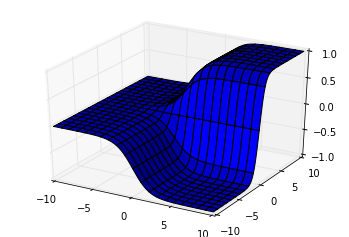

In [129]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as plt3

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def Wcalc(wh,mh,W_mat):
    W_mat = np.zeros((np.size(wh),np.size(mh)))
    for i in range(np.size(wh)):
        for j in range(np.size(mh)):
            W_mat[i,j] = np.tanh(wh[i]) * sigmoid(wh[j])
    return W_mat

wh = np.linspace(10,-10,100+1)
mh = np.linspace(10,-10,100+1)
xx,yy = np.meshgrid(wh,mh)
W_mat = Wcalc(wh,mh,W_mat)
print(np.shape(wh),np.shape(mh),np.shape(xx),np.shape(yy),np.shape(W_mat))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=xx,Y=yy,Z=W_mat,rstride=5,cstride=5)      
